In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import dask
import dask.array as da
import dask.dataframe as dd

Matplotlib is building the font cache; this may take a moment.


In [2]:
%%time
import polars as pl
train_series = (pl.scan_parquet('train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
#                         (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 1min 15s, sys: 14.2 s, total: 1min 29s
Wall time: 1min 46s


In [3]:
train_series.head(10)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4,2018-08-14 15:30:20,2.6368,0.0215
5,038441c925bb,5,2018-08-14 15:30:25,2.6367,0.0217
6,038441c925bb,6,2018-08-14 15:30:30,2.6367,0.0217
7,038441c925bb,7,2018-08-14 15:30:35,2.6367,0.0218
8,038441c925bb,8,2018-08-14 15:30:40,2.7980,0.0223
9,038441c925bb,9,2018-08-14 15:30:45,3.0847,0.0217


In [4]:
from pandas.api.types import is_datetime64_ns_dtype
import gc

import warnings
warnings.filterwarnings("ignore")

def reduce_mem_usage(df):
    
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    df['series_id'] = df['series_id'].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [5]:
train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 3416.54 MB
Memory usage after optimization is: 2684.43 MB
Decreased by 21.43%


In [6]:
train_events = (pl.scan_csv('train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

In [7]:
train_events.head(10)

,series_id,night,event,step,timestamp,year,month,day,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN


In [8]:
train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')

In [9]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
series_has_NaN.value_counts()

True     240
False     37
Name: step, dtype: int64

In [13]:
# series with na
NaN_series = series_has_NaN[series_has_NaN].index.tolist()

In [26]:
filtered_df = train_events[train_events['series_id'] == '038441c925bb']

In [27]:
filtered_df.head(100)

,series_id,night,event,step,timestamp,year,month,day,hour,awake
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0,1
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0,0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0,1
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0,0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0,1
5,038441c925bb,3,wakeup,44400.0,2018-08-17 05:10:00,2018.0,8.0,17.0,5.0,0
6,038441c925bb,4,onset,57240.0,2018-08-17 23:00:00,2018.0,8.0,17.0,23.0,1
7,038441c925bb,4,wakeup,62856.0,2018-08-18 06:48:00,2018.0,8.0,18.0,6.0,0
8,038441c925bb,5,onset,NaN,NaT,NaN,NaN,NaN,NaN,1
9,038441c925bb,5,wakeup,NaN,NaT,NaN,NaN,NaN,NaN,0


In [28]:
# Create a dictionary to store missing value ratio tables for each series
missing_ratio_tables = {}

# Loop through each series_id and calculate the missing value ratio table
for series_id in NaN_series:
    # Filter the DataFrame for the current series_id
    filtered_df = train_events[train_events['series_id'] == series_id]
    
    # Calculate the missing value ratio for each column
    missing_ratio = filtered_df.isnull().mean()
    
    # Add the missing value ratio table to the dictionary
    missing_ratio_tables[series_id] = missing_ratio

# Create a DataFrame from the dictionary
missing_ratio_df = pd.DataFrame(missing_ratio_tables)

# Transpose the DataFrame for a more readable format
missing_ratio_df = missing_ratio_df.T

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the missing value ratio table for each series
print(missing_ratio_df)

              series_id  night  event      step  timestamp      year  \
038441c925bb        0.0    0.0    0.0  0.173913   0.173913  0.173913   
03d92c9f6f8a        0.0    0.0    0.0  0.783784   0.783784  0.783784   
0402a003dae9        0.0    0.0    0.0  0.250000   0.250000  0.250000   
04f547b8017d        0.0    0.0    0.0  0.432432   0.432432  0.432432   
05e1944c3818        0.0    0.0    0.0  0.125000   0.125000  0.125000   
062cae666e2a        0.0    0.0    0.0  0.884615   0.884615  0.884615   
062dbd4c95e6        0.0    0.0    0.0  0.681818   0.681818  0.681818   
0cd1e3d0ed95        0.0    0.0    0.0  0.714286   0.714286  0.714286   
0ce74d6d2106        0.0    0.0    0.0  0.100000   0.100000  0.100000   
0d0ad1e77851        0.0    0.0    0.0  0.166667   0.166667  0.166667   
0dee4fda51c3        0.0    0.0    0.0  0.166667   0.166667  0.166667   
0ec9fc461819        0.0    0.0    0.0  0.090909   0.090909  0.090909   
0ef7d94fde99        0.0    0.0    0.0  0.045455   0.045455  0.04

In [49]:
def filter_out(df, column , ratio):
    filtered_df = df[df[column]<= ratio]
    filtered_series = filtered_df.index.tolist()
    return filtered_series

In [50]:
percent_5_missing =filter_out(missing_ratio_df, 'step', 0.05)

In [51]:
percent_5_missing

['0ef7d94fde99',
 '154fe824ed87',
 '188d4b7cd28b',
 '1b92be89db4c',
 '27f09a6a858f',
 '449766346eb1',
 '4ab54be1a403',
 '51b23d177971',
 '5f76965e10cf',
 '653622ac8363',
 '752900afe3a6',
 '7df249527c63',
 '804594bb1f06',
 '8877a6586606',
 '8a306e0890c0',
 '8fb18e36697d',
 '91cb6c98201f',
 '99237ce045e4',
 'bdfce9ce62b9',
 'bfe41e96d12f',
 'd93b0c7de16b',
 'e8d0a37c3eba',
 'f6d2cc003183',
 'f7eb179216c2',
 'fcca183903b7']

In [107]:
df = train_events[train_events['series_id'] == 'fcca183903b7' ].step

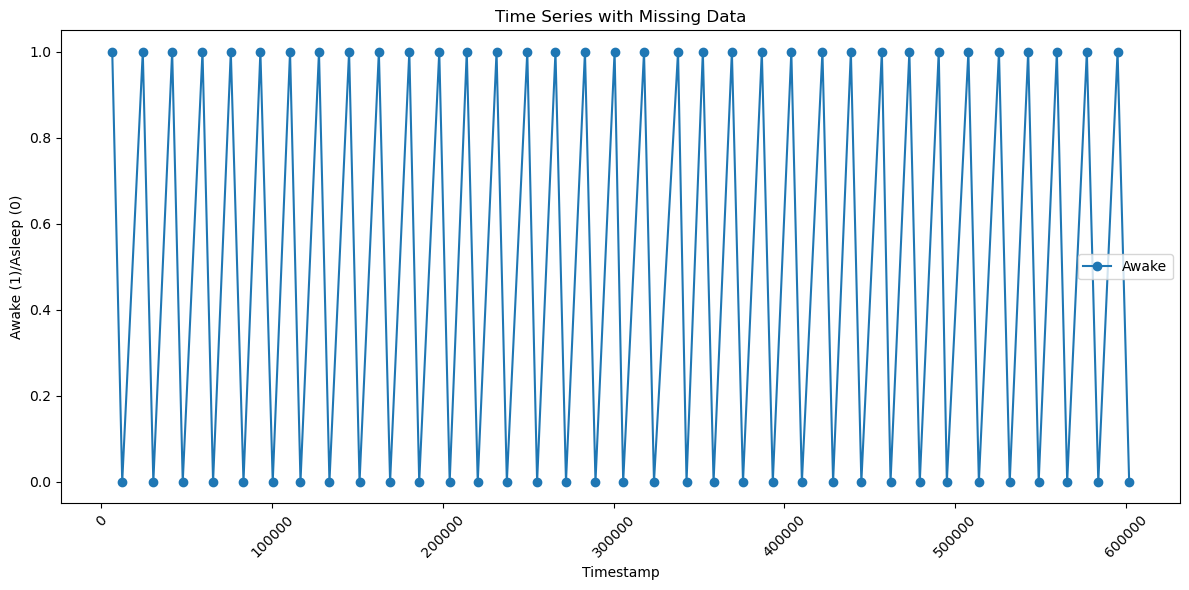

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the 'awake' column
ax.plot(df['step'], df['awake'], marker='o', label='Awake', linestyle='-')

# Fill missing data areas with a gray background
for index, row in df.iterrows():
    if np.isnan(row['step']):
        start_idx = index
        end_idx = index
        while end_idx < len(df) and np.isnan(df.at[end_idx, 'step']):
            end_idx += 1
        #ax.fill_between(df['timestamp'].iloc[start_idx:end_idx], 0, 1, color='gray', alpha=0.5, label='Missing Data')

# Set labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('Awake (1)/Asleep (0)')
ax.set_title('Time Series with Missing Data')

# Show the legend
ax.legend()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [79]:
def find_missing_indices(time_series):
    """
    Find the indices of missing (NaN) values in a time series.

    Args:
        time_series (numpy.ndarray or list): The time series data.

    Returns:
        list: A list of indices where missing values occur.
    """
    if isinstance(time_series, list):
        time_series = np.array(time_series)
    elif isinstance(time_series, pd.Series):
        time_series = time_series.values

    missing_indices = np.where(np.isnan(time_series))[0]

    return missing_indices

In [108]:
find_missing_indices(df)

array([70, 71])

In [98]:
def get_adjacent_rows(df, missing_index):
    start_index = max(0, missing_index - 3)
    end_index = min(len(df) - 1, missing_index + 3)
    return df.iloc[start_index:end_index + 1]

In [102]:
train_events = train_events[['series_id',  'night',   'event',      'step']]

In [104]:
missing_index_dic = {}
missing_row = {}
for series in percent_5_missing:
    ts= train_events[train_events['series_id'] == series ].step
    df = train_events[train_events['series_id'] == series ]
    missing_indices = find_missing_indices(ts)
    missing_index_dic[series] = missing_indices
    missing_row[series] = df.iloc[missing_indices]
    
    adjacent_rows = []
    for missing_index in missing_indices:
        adjacent_rows.append(get_adjacent_rows(df, missing_index))
        
    missing_row[series] = adjacent_rows

In [117]:
df_t = train_events[train_events['series_id'] == '0ef7d94fde99']

In [119]:
# Find missing value indices
missing_indices = np.where(df_t.isna())  # This returns a tuple of row and column indices

# Extract row and column indices separately
missing_rows = missing_indices[0]
for row in missing_rows:
    adjacent_rows = get_adjacent_rows(df_t, row)
    print(adjacent_rows)
    print()

        series_id  night   event      step
833  0ef7d94fde99     20  wakeup  336912.0
834  0ef7d94fde99     21   onset  350856.0
835  0ef7d94fde99     21  wakeup  351624.0
836  0ef7d94fde99     22   onset       NaN
837  0ef7d94fde99     22  wakeup       NaN

        series_id  night   event      step
834  0ef7d94fde99     21   onset  350856.0
835  0ef7d94fde99     21  wakeup  351624.0
836  0ef7d94fde99     22   onset       NaN
837  0ef7d94fde99     22  wakeup       NaN



In [105]:
# Iterate through the dictionary and print missing rows for each series
for series, missing_df in missing_row.items():
    print(f'Series ID: {series}')
    print(missing_df)
    print('-' * 50)  # Separating lines for clarity

Series ID: 0ef7d94fde99
[        series_id  night   event      step
833  0ef7d94fde99     20  wakeup  336912.0
834  0ef7d94fde99     21   onset  350856.0
835  0ef7d94fde99     21  wakeup  351624.0
836  0ef7d94fde99     22   onset       NaN
837  0ef7d94fde99     22  wakeup       NaN,         series_id  night   event      step
834  0ef7d94fde99     21   onset  350856.0
835  0ef7d94fde99     21  wakeup  351624.0
836  0ef7d94fde99     22   onset       NaN
837  0ef7d94fde99     22  wakeup       NaN]
--------------------------------------------------
Series ID: 154fe824ed87
[         series_id  night   event      step
1421  154fe824ed87     28  wakeup  479904.0
1422  154fe824ed87     29   onset  491688.0
1423  154fe824ed87     29  wakeup  497832.0
1424  154fe824ed87     30   onset       NaN
1425  154fe824ed87     30  wakeup  514980.0
1426  154fe824ed87     31   onset  525012.0
1427  154fe824ed87     31  wakeup  532260.0,          series_id  night   event      step
1425  154fe824ed87     30  

In [106]:
missing_index_dic

{'0ef7d94fde99': array([42, 43]),
 '154fe824ed87': array([58, 62, 63]),
 '188d4b7cd28b': array([18, 19]),
 '1b92be89db4c': array([20, 21]),
 '27f09a6a858f': array([2, 3]),
 '449766346eb1': array([22, 23]),
 '4ab54be1a403': array([40, 41]),
 '51b23d177971': array([10, 11]),
 '5f76965e10cf': array([30, 31]),
 '653622ac8363': array([14, 15]),
 '752900afe3a6': array([42, 43]),
 '7df249527c63': array([2, 3]),
 '804594bb1f06': array([46, 47]),
 '8877a6586606': array([22, 23]),
 '8a306e0890c0': array([46, 47]),
 '8fb18e36697d': array([44, 45]),
 '91cb6c98201f': array([46, 47]),
 '99237ce045e4': array([46, 47]),
 'bdfce9ce62b9': array([4, 5]),
 'bfe41e96d12f': array([44, 45]),
 'd93b0c7de16b': array([0, 1]),
 'e8d0a37c3eba': array([64, 65]),
 'f6d2cc003183': array([0, 1]),
 'f7eb179216c2': array([44, 45]),
 'fcca183903b7': array([70, 71])}

In [11]:
# series with no missing values
no_NaN_series = series_has_NaN[~series_has_NaN].index.tolist()
no_NaN_series

['08db4255286f',
 '0a96f4993bd7',
 '0cfc06c129cc',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '18b61dd5aae8',
 '29c75c018220',
 '31011ade7c0a',
 '3452b878e596',
 '349c5562ee2c',
 '3664fe9233f9',
 '483d6545417f',
 '55a47ff9dc8a',
 '5acc9d63b5fd',
 '5f94bb3e1bed',
 '655f19eabf1e',
 '67f5fc60e494',
 '72bbd1ac3edf',
 '76237b9406d5',
 '7822ee8fe3ec',
 '89bd631d1769',
 '8e32047cbc1f',
 '939932f1822d',
 '9ee455e4770d',
 'a596ad0b82aa',
 'a9a2f7fac455',
 'a9e5f5314bcb',
 'af91d9a50547',
 'b364205aba43',
 'c535634d7dcd',
 'c6788e579967',
 'c68260cc9e8f',
 'ca730dbf521d',
 'd150801f3145',
 'd25e479ecbb7',
 'd515236bdeec',
 'd5e47b94477e']